In [ ]:
# Install packages (Colab only)
#!pip install fastdtw openpyxl

# Import libraries
import pandas as pd
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# File paths
reference_path = '/content/drive/My Drive/Modified_PCA_WellLog_Data/Observation_Well_1.xlsx'
observation_paths = [
    '/content/drive/My Drive/Modified_PCA_WellLog_Data/Observation_Well_2.xlsx',
    '/content/drive/My Drive/Modified_PCA_WellLog_Data/Observation_Well_3.xlsx'
]

# Load Reference Well
reference_well = pd.read_excel(reference_path)
reference_tops = reference_well.groupby('Reservoir zone')['DEPTH'].min()

Mounted at /content/drive


In [ ]:
reference_well[['CGR', 'SGR', 'DT', 'RHOB']].head()

,CGR,SGR,DT,RHOB
0,35.530800,51.421101,73.890297,2.5925
1,32.040798,43.052200,70.031898,2.6118
2,27.593300,35.163300,66.321701,2.6176
3,22.495001,28.146099,63.666199,2.6154
4,18.608101,22.703300,62.256699,2.6100


# Fast DTW without any weights

In [ ]:
# Settings
log_columns = ['CGR', 'SGR', 'DT', 'RHOB']
#log_curve_name = 'SGR'
#layers_colors = ['#c6dbef', '#fee391', '#c6dbef', '#fee391', '#c6dbef', '#fee391']

# Initialize storage
all_errors = []
all_predictions = {}

# Process each Observation Well
for idx, obs_path in enumerate(observation_paths):
    print(f"\n=== Processing Observation Well {idx+1} ===")

    observation_well = pd.read_excel(obs_path)

    # Prepare feature vectors
    #reference_logs = reference_well[log_columns].values
    #observation_logs = observation_well[log_columns].values

    # Extract raw logs
    X_ref_raw = reference_well[log_columns].values
    X_obs_raw = observation_well[log_columns].values

    #def weighted_euclidean(u, v, weights):
        #return np.sqrt(np.sum(weights * (u - v)**2))

    #weights = np.array([1, 1, 1, 1])  # Emphasize SGR and DT

    distance, path = fastdtw(X_ref_raw, X_obs_raw, dist=euclidean)

    # Predict tops
    reference_zones = reference_well.groupby('Reservoir zone')
    predicted_tops = {}

    for zone_name, group in reference_zones:
        ref_top_depth = group['DEPTH'].min()
        matched_obs_depths = [observation_well['DEPTH'].iloc[obs_idx] for ref_idx, obs_idx in path if reference_well['DEPTH'].iloc[ref_idx] == ref_top_depth]
        if matched_obs_depths:
            predicted_tops[zone_name] = np.median(matched_obs_depths)

    all_predictions[f'Observation Well {idx+1}'] = predicted_tops

    # Compare with actual tops
    obs_actual_tops = observation_well.groupby('Reservoir zone')['DEPTH'].min()

    common_zones = set(predicted_tops.keys()) & set(obs_actual_tops.index) # some wells skipped for obs. well 3

    pred = []
    actual = []

    # Sorted zone names
    zone_order_1 = ['USV-2', 'USV-3', 'USV-4', 'USV-5', 'USV-6']
    zone_order_2 = ['USV-5']

    print("\nComparison of Predicted vs Actual Tops:")
    print(f"{'Zone':<10}{'Predicted (m)':<20}{'Actual (m)':<20}{'Error (m)':<20}")

    if idx == 0:
      for zone in zone_order_1:
          if zone in common_zones:
              pred_depth = predicted_tops[zone]
              act_depth = obs_actual_tops[zone]
              error = pred_depth - act_depth
              pred.append(pred_depth)
              actual.append(act_depth)
              print(f"{zone:<10}{pred_depth:<20.2f}{act_depth:<20.2f}{error:<20.2f}")
              all_errors.append(error)

    elif idx == 1:
      for zone in zone_order_2:
          if zone in common_zones:
              pred_depth = predicted_tops[zone]
              act_depth = obs_actual_tops[zone]
              error = pred_depth - act_depth
              pred.append(pred_depth)
              actual.append(act_depth)
              print(f"{zone:<10}{pred_depth:<20.2f}{act_depth:<20.2f}{error:<20.2f}")
              all_errors.append(error)
    #print("")
    print("-"*50)

print()
total_mae = np.sum([abs(i) for i in all_errors])/len(all_errors)
print("Total_MAE", total_mae)


=== Processing Observation Well 1 ===

Comparison of Predicted vs Actual Tops:
Zone      Predicted (m)       Actual (m)          Error (m)           
USV-2     2787.85             2787.85             0.00                
USV-3     2790.44             2790.60             -0.15               
USV-4     2793.95             2795.17             -1.22               
USV-5     2820.85             2819.55             1.30                
USV-6     2874.11             2873.50             0.61                
--------------------------------------------------

=== Processing Observation Well 2 ===

Comparison of Predicted vs Actual Tops:
Zone      Predicted (m)       Actual (m)          Error (m)           
USV-5     2749.90             2749.90             0.00                
--------------------------------------------------

Total_MAE 0.546100000000024


# Fast DTW with weighted cost



In [ ]:
# Settings
log_columns = ['CGR', 'SGR', 'DT', 'RHOB']
#log_curve_name = 'SGR'
#layers_colors = ['#c6dbef', '#fee391', '#c6dbef', '#fee391', '#c6dbef', '#fee391']

# Initialize storage
all_errors = []
all_predictions = {}

# Process each Observation Well
for idx, obs_path in enumerate(observation_paths):
    print(f"\n=== Processing Observation Well {idx+1} ===")

    observation_well = pd.read_excel(obs_path)

    # Prepare feature vectors
    #reference_logs = reference_well[log_columns].values
    #observation_logs = observation_well[log_columns].values

    # Extract raw logs
    X_ref_raw = reference_well[log_columns].values
    X_obs_raw = observation_well[log_columns].values

    def weighted_euclidean(u, v, weights):
        return np.sqrt(np.sum(weights * (u - v)**2))

    weights = np.array([7, 3, 5, 1])  # Emphasize SGR and DT

    distance, path = fastdtw(X_ref_raw, X_obs_raw, dist=lambda u, v: weighted_euclidean(u, v, weights))

    # Predict tops
    reference_zones = reference_well.groupby('Reservoir zone')
    predicted_tops = {}

    for zone_name, group in reference_zones:
        ref_top_depth = group['DEPTH'].min()
        matched_obs_depths = [observation_well['DEPTH'].iloc[obs_idx] for ref_idx, obs_idx in path if reference_well['DEPTH'].iloc[ref_idx] == ref_top_depth]
        if matched_obs_depths:
            predicted_tops[zone_name] = np.median(matched_obs_depths)

    all_predictions[f'Observation Well {idx+1}'] = predicted_tops

    # Compare with actual tops
    obs_actual_tops = observation_well.groupby('Reservoir zone')['DEPTH'].min()

    common_zones = set(predicted_tops.keys()) & set(obs_actual_tops.index) # some wells skipped for obs. well 3

    pred = []
    actual = []

    # Sorted zone names
    zone_order_1 = ['USV-2', 'USV-3', 'USV-4', 'USV-5', 'USV-6']
    zone_order_2 = ['USV-5']

    print("\nComparison of Predicted vs Actual Tops:")
    print(f"{'Zone':<10}{'Predicted (m)':<20}{'Actual (m)':<20}{'Error (m)':<20}")

    if idx == 0:
      for zone in zone_order_1:
          if zone in common_zones:
              pred_depth = predicted_tops[zone]
              act_depth = obs_actual_tops[zone]
              error = pred_depth - act_depth
              pred.append(pred_depth)
              actual.append(act_depth)
              print(f"{zone:<10}{pred_depth:<20.2f}{act_depth:<20.2f}{error:<20.2f}")
              all_errors.append(error)

    elif idx == 1:
      for zone in zone_order_2:
          if zone in common_zones:
              pred_depth = predicted_tops[zone]
              act_depth = obs_actual_tops[zone]
              error = pred_depth - act_depth
              pred.append(pred_depth)
              actual.append(act_depth)
              print(f"{zone:<10}{pred_depth:<20.2f}{act_depth:<20.2f}{error:<20.2f}")
              all_errors.append(error)
    #print("")
    print("-"*50)

print()
total_mae = np.sum([abs(i) for i in all_errors])/len(all_errors)
print("Total_MAE", total_mae)


=== Processing Observation Well 1 ===

Comparison of Predicted vs Actual Tops:
Zone      Predicted (m)       Actual (m)          Error (m)           
USV-2     2787.85             2787.85             0.00                
USV-3     2790.44             2790.60             -0.15               
USV-4     2793.95             2795.17             -1.22               
USV-5     2820.16             2819.55             0.61                
USV-6     2873.96             2873.50             0.46                
--------------------------------------------------

=== Processing Observation Well 2 ===

Comparison of Predicted vs Actual Tops:
Zone      Predicted (m)       Actual (m)          Error (m)           
USV-5     2749.90             2749.90             0.00                
--------------------------------------------------

Total_MAE 0.40639999999992443


# Visualizations

In [ ]:
all_predictions

{'Observation Well 1': {'USV-1': np.float64(2762.0),
  'USV-2': np.float64(2787.8532),
  'USV-3': np.float64(2790.444),
  'USV-4': np.float64(2793.9492),
  'USV-5': np.float64(2820.162),
  'USV-6': np.float64(2873.9592)},
 'Observation Well 2': {'USV-1': np.float64(2730.0),
  'USV-2': np.float64(2730.39641),
  'USV-3': np.float64(2730.39641),
  'USV-4': np.float64(2734.35881),
  'USV-5': np.float64(2749.90361),
  'USV-6': np.float64(2782.82202)}}

In [ ]:
# Remove specified keys
all_predictions['Observation Well 1'].pop('USV-1', None)
for key in ['USV-1', 'USV-2', 'USV-3', 'USV-4', 'USV-6']:
    all_predictions['Observation Well 2'].pop(key, None)

# Result
print(all_predictions)

{'Observation Well 1': {'USV-2': np.float64(2787.8532), 'USV-3': np.float64(2790.444), 'USV-4': np.float64(2793.9492), 'USV-5': np.float64(2820.162), 'USV-6': np.float64(2873.9592)}, 'Observation Well 2': {'USV-5': np.float64(2749.90361)}}


## Plot 1: Prediction

In [ ]:
max_depth

2890.0

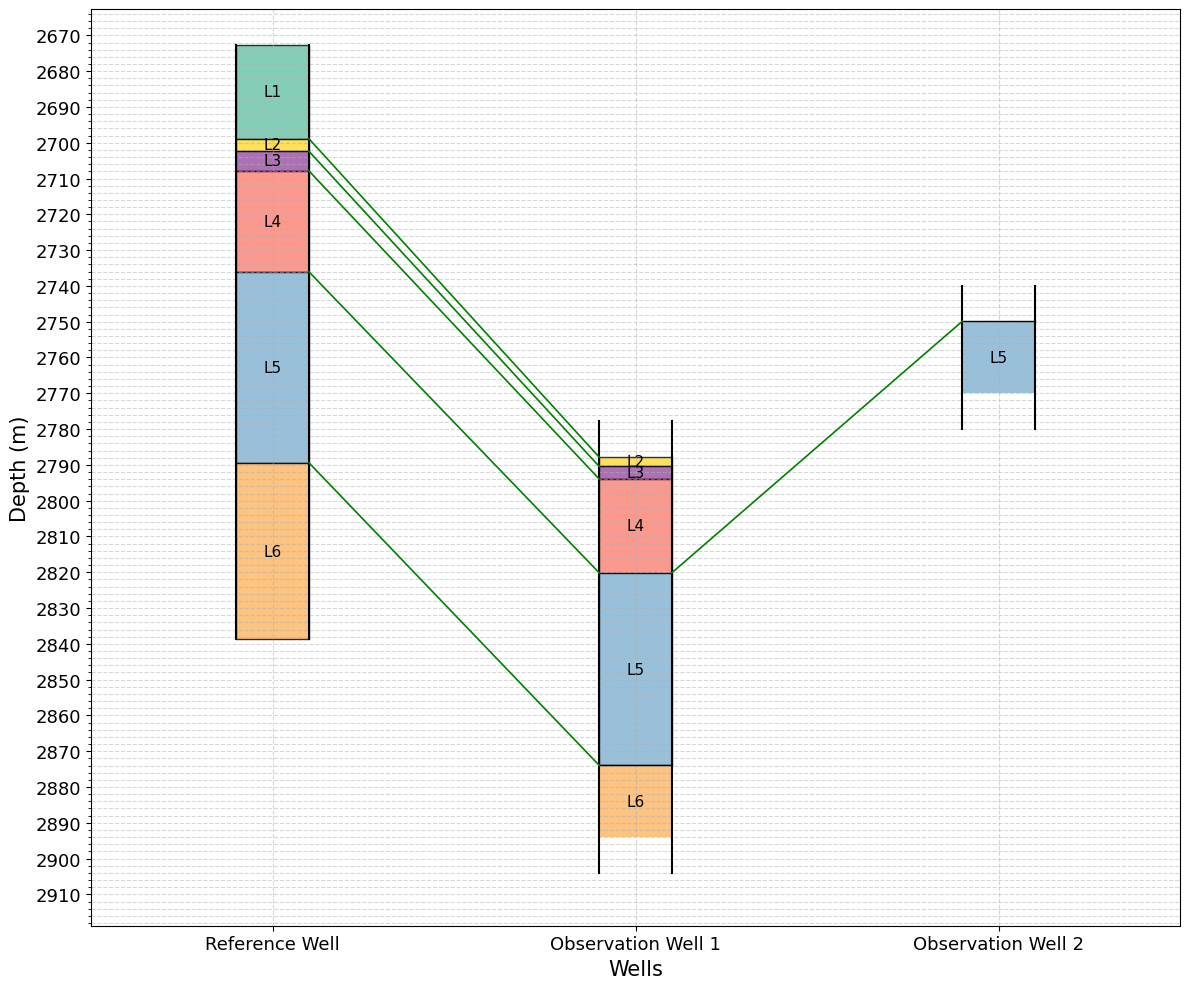

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Updated zone colors
zone_color_map = {
    'USV-1': '#66c2a5',  # L1 - green
    'USV-2': '#ffd92f',  # L2 - yellow
    'USV-3': '#984ea3',  # L3 - distinct purple
    'USV-4': '#fb8072',  # L4
    'USV-5': '#80b1d3',  # L5
    'USV-6': '#fdb462'   # L6
}

zone_label_map = {
    'USV-1': 'L1',
    'USV-2': 'L2',
    'USV-3': 'L3',
    'USV-4': 'L4',
    'USV-5': 'L5',
    'USV-6': 'L6'
}

# --- Reference Data ---
ref_tops = reference_well.groupby('Reservoir zone')['DEPTH'].min()
sorted_zones = ref_tops.sort_values().index.tolist()

# --- Plot Setup ---
fig, ax = plt.subplots(figsize=(12, 10))
x_positions = [-2, 0, 2]  # Reference, Obs1, Obs2
min_depth = reference_well['DEPTH'].min()
max_depth = reference_well['DEPTH'].max()

# --- Plot Reference Well ---
x_center = x_positions[0]
ax.plot([x_center - 0.2, x_center - 0.2], [min_depth, max_depth], color='black')
ax.plot([x_center + 0.2, x_center + 0.2], [min_depth, max_depth], color='black')

for i, zone in enumerate(sorted_zones):
    top = ref_tops[zone]
    base = ref_tops[sorted_zones[i + 1]] if i < len(sorted_zones) - 1 else max_depth
    ax.fill_betweenx([top, base], x_center - 0.2, x_center + 0.2,
                     color=zone_color_map[zone], edgecolor='black', alpha=0.8)
    ax.text(x_center, (top + base) / 2, zone_label_map[zone],
            ha='center', va='center', fontsize=11)

# --- Plot Observation Wells from Predictions Only ---
for idx, well_key in enumerate(['Observation Well 1', 'Observation Well 2'], start=1):
    x_center = x_positions[idx]
    predictions = all_predictions[well_key]

    sorted_pred_zones = sorted(predictions.items(), key=lambda x: x[1])
    zone_keys = [z for z, _ in sorted_pred_zones]

    top_of_first_layer = predictions[zone_keys[0]] - 10
    bottom_of_last_layer = predictions[zone_keys[-1]] + 30

    ax.plot([x_center - 0.2, x_center - 0.2], [top_of_first_layer, bottom_of_last_layer], color='black')
    ax.plot([x_center + 0.2, x_center + 0.2], [top_of_first_layer, bottom_of_last_layer], color='black')

    for i, zone in enumerate(zone_keys):
        top = predictions[zone]
        base = predictions[zone_keys[i + 1]] if i < len(zone_keys) - 1 else top + 20

        color = zone_color_map.get(zone, '#cccccc')
        label = zone_label_map.get(zone, zone)

        skip_bottom_edge = (
            (zone == 'USV-6' and well_key == 'Observation Well 1') or
            (zone == 'USV-5' and well_key == 'Observation Well 2')
        )

        if skip_bottom_edge:
            ax.fill_betweenx([top, base], x_center - 0.2, x_center + 0.2,
                             color=color, edgecolor=None, alpha=0.8)
            ax.plot([x_center - 0.2, x_center + 0.2], [top, top], color='black', linewidth=1)
        else:
            ax.fill_betweenx([top, base], x_center - 0.2, x_center + 0.2,
                             color=color, edgecolor='black', alpha=0.8)

        ax.text(x_center, (top + base) / 2, label, ha='center', va='center', fontsize=11)

# --- Correlation Lines ---
for zone in sorted_zones:
    if zone in all_predictions['Observation Well 1']:
        x0, x1 = x_positions[0] + 0.2, x_positions[1] - 0.2
        y0 = ref_tops[zone]
        y1 = all_predictions['Observation Well 1'][zone]
        ax.plot([x0, x1], [y0, y1], color='green', linestyle='-', linewidth=1.2)

if 'USV-5' in all_predictions['Observation Well 1'] and 'USV-5' in all_predictions['Observation Well 2']:
    x1, x2 = x_positions[1] + 0.2, x_positions[2] - 0.2
    y1 = all_predictions['Observation Well 1']['USV-5']
    y2 = all_predictions['Observation Well 2']['USV-5']
    ax.plot([x1, x2], [y1, y2], color='green', linestyle='-', linewidth=1.2)

# --- Final Styling ---
ax.set_ylim(max_depth + 80, min_depth - 10)
ax.set_xlim(-3, 3)
ax.set_xticks(x_positions)
ax.set_xticklabels(['Reference Well', 'Observation Well 1', 'Observation Well 2'], fontsize=13)
ax.set_xlabel('Wells', fontsize=15)
ax.set_ylabel('Depth (m)', fontsize=15)
#ax.set_title('FastDTW Lithostratigraphic Correlation Across Wells', fontsize=17)
ax.tick_params(axis='y', labelsize=13)
ax.grid(True, which='both', linestyle='--', alpha=0.5)
ax.yaxis.set_minor_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(10))

plt.tight_layout()
plt.savefig("predicted_lithostratigraphic_correlation.pdf", format='pdf', dpi=300)
plt.show()

## Plot 2: Ground Truth

In [ ]:
min_depth

2672.638916

In [ ]:
max_depth

2890.0

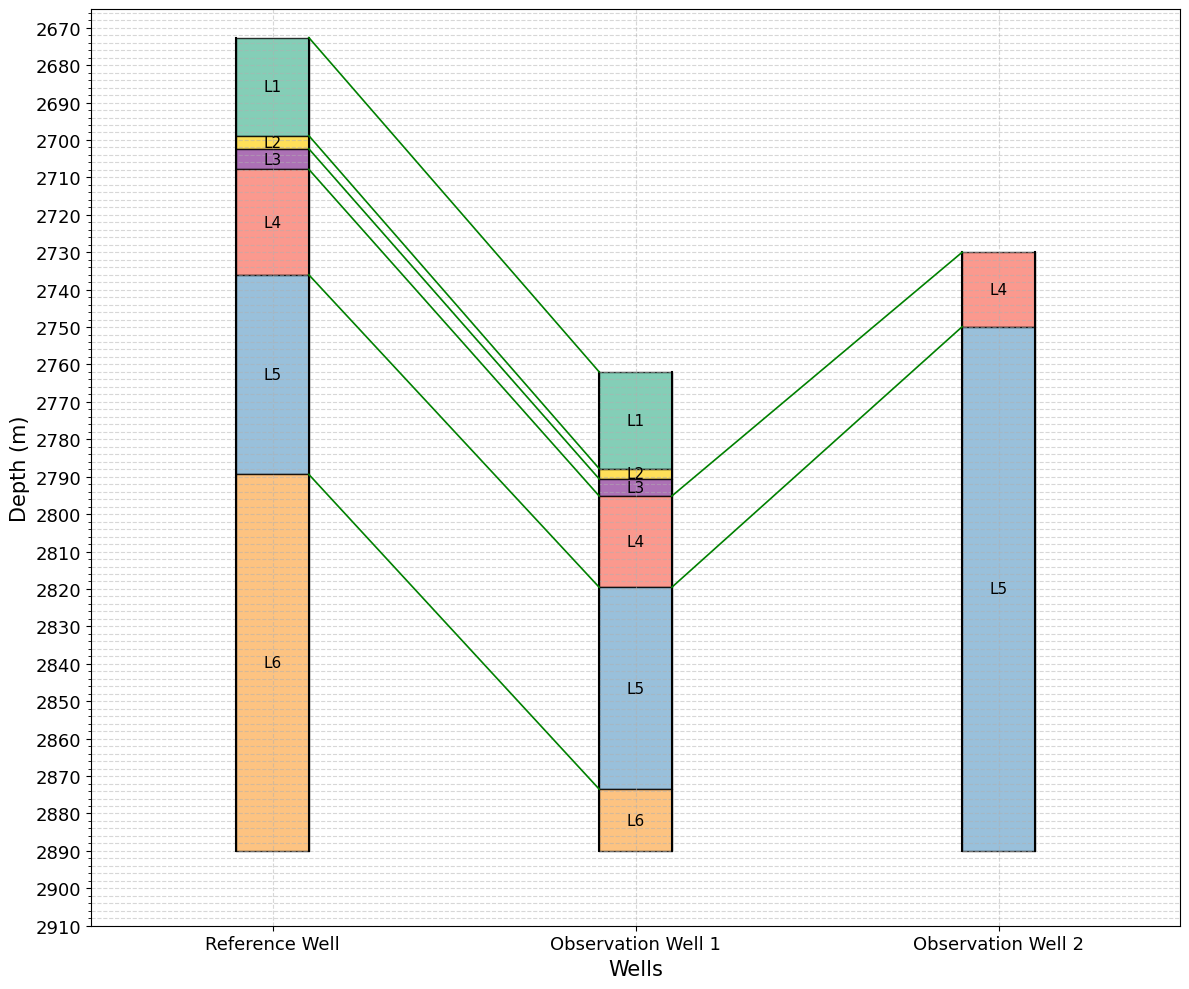

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# File paths
reference_path = '/content/drive/My Drive/Modified_PCA_WellLog_Data/Observation_Well_1.xlsx'
observation_paths = [
    '/content/drive/My Drive/Modified_PCA_WellLog_Data/Observation_Well_2.xlsx',
    '/content/drive/My Drive/Modified_PCA_WellLog_Data/Observation_Well_3.xlsx'
]

# Load data
reference_well = pd.read_excel(reference_path)
obs_wells = [pd.read_excel(p) for p in observation_paths]
wells = [reference_well] + obs_wells

# Updated zone colors
zone_color_map = {
    'USV-1': '#66c2a5',  # L1 - green
    'USV-2': '#ffd92f',  # L2 - yellow
    'USV-3': '#984ea3',  # L3 - distinct purple
    'USV-4': '#fb8072',  # L4
    'USV-5': '#80b1d3',  # L5
    'USV-6': '#fdb462'   # L6
}


zone_label_map = {
    'USV-1': 'L1',
    'USV-2': 'L2',
    'USV-3': 'L3',
    'USV-4': 'L4',
    'USV-5': 'L5',
    'USV-6': 'L6'
}

# Determine global depth range
min_depth = min(w['DEPTH'].min() for w in wells)
max_depth = max(w['DEPTH'].max() for w in wells)

# X positions for plotting
x_positions = [-2, 0, 2]  # Ref, Obs1, Obs2

# Collect tops per well for correlation lines
tops_per_well = []

# Plot setup
fig, ax = plt.subplots(figsize=(12, 10))

# Plot each well
for idx, well in enumerate(wells):
    x_center = x_positions[idx]
    tops = well.groupby('Reservoir zone')['DEPTH'].min()
    sorted_zones = tops.sort_values().index.tolist()
    tops_per_well.append(tops)

    top_of_first_layer = tops[sorted_zones[0]]
    base_of_last_layer = tops[sorted_zones[-1]] + 15

    ax.plot([x_center - 0.2, x_center - 0.2], [top_of_first_layer, max_depth], color='black')
    ax.plot([x_center + 0.2, x_center + 0.2], [top_of_first_layer, max_depth], color='black')

    for i, zone in enumerate(sorted_zones):
        top = tops[zone]
        base = tops[sorted_zones[i + 1]] if i < len(sorted_zones) - 1 else max_depth
        color = zone_color_map.get(zone, '#cccccc')
        label = zone_label_map.get(zone, zone)
        ax.fill_betweenx([top, base], x_center - 0.2, x_center + 0.2,
                         color=color, edgecolor='black', alpha=0.8)
        ax.text(x_center, (top + base) / 2, label, ha='center', va='center', fontsize=11)

# Correlation lines
for i in range(len(wells) - 1):
    tops_left = tops_per_well[i]
    tops_right = tops_per_well[i + 1]
    for zone in tops_left.index.intersection(tops_right.index):
        x0 = x_positions[i] + 0.2
        x1 = x_positions[i + 1] - 0.2
        y0 = tops_left[zone]
        y1 = tops_right[zone]
        ax.plot([x0, x1], [y0, y1], color='green', linewidth=1.2)

# Styling
ax.set_ylim(max_depth + 20, min_depth - 10)
ax.set_xlim(-3, 3)
ax.set_xticks(x_positions)
ax.set_xticklabels(['Reference Well', 'Observation Well 1', 'Observation Well 2'], fontsize=13)
ax.set_xlabel('Wells', fontsize=15)
ax.set_ylabel('Depth (m)', fontsize=15)
#ax.set_title('Ground Truth Lithostratigraphic Correlation Across Wells', fontsize=17)
ax.tick_params(axis='y', labelsize=13)
ax.grid(True, which='both', linestyle='--', alpha=0.5)
ax.yaxis.set_minor_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_ylim(2910, 2665)  # Y-axis limit fixed

plt.tight_layout()
plt.savefig("groundtruth_lithostratigraphic_correlation.pdf", format='pdf', dpi=300)  # Save before showing
plt.show()

# Other Visualizations

## 3 wells coordinates visualization


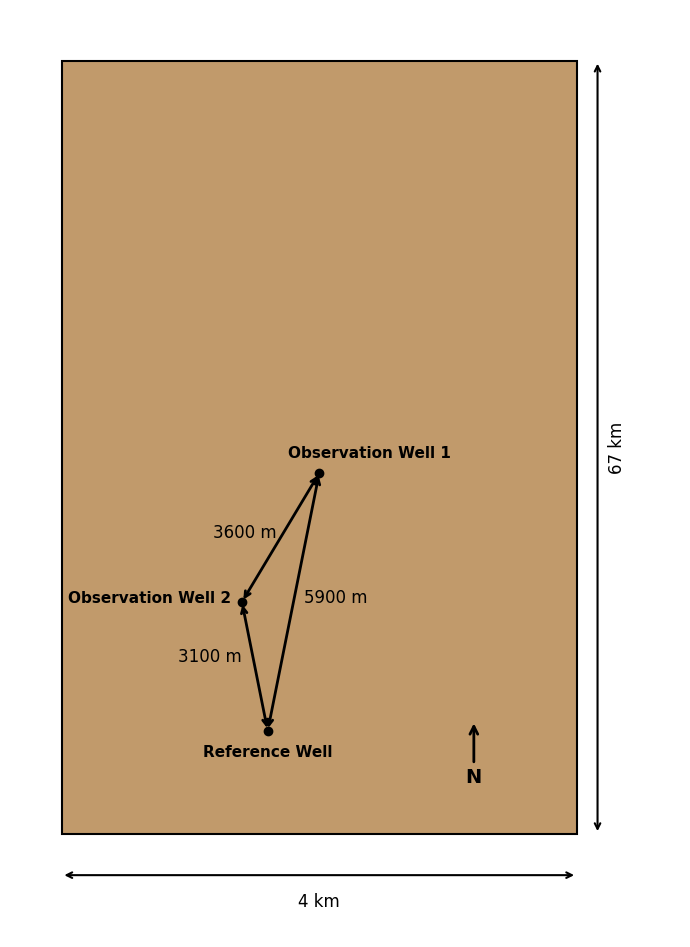

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Field rectangle dimensions (not to scale)
field_width = 10   # arbitrary units
field_height = 15

# Coordinates for wells (manually spaced for clarity)
wells = {
    'Reference Well': (4, 2),
    'Observation Well 2': (3.5, 4.5),
    'Observation Well 1': (5, 7)
}

# Pairs of wells with distances to annotate
connections = [
    ('Reference Well', 'Observation Well 2', '3100 m'),
    ('Observation Well 2', 'Observation Well 1', '3600 m'),
    ('Reference Well', 'Observation Well 1', '5900 m')
]

fig, ax = plt.subplots(figsize=(7, 11))
ax.set_aspect('equal')

# Draw the brown field rectangle
field_rect = patches.Rectangle((0, 0), field_width, field_height,
                               linewidth=1.5, edgecolor='black', facecolor='#c19a6b')
ax.add_patch(field_rect)

# Plot wells with customized label positioning
for well, (x, y) in wells.items():
    ax.plot(x, y, 'ko')
    if well == 'Reference Well':
        ax.text(x, y - 0.5, well, fontsize=11, fontweight='bold', ha='center')  # Below
    elif well == 'Observation Well 2':
        ax.text(x - 0.2, y, well, fontsize=11, fontweight='bold', ha='right')   # Left
    else:
        ax.text(x - 0.6, y + 0.3, well, fontsize=11, fontweight='bold')         # Default (top-left)

# Draw distance arrows and labels (double-headed)
for start, end, label in connections:
    x_start, y_start = wells[start]
    x_end, y_end = wells[end]
    ax.annotate('', xy=(x_end, y_end), xytext=(x_start, y_start),
                arrowprops=dict(arrowstyle='<->', lw=2, color='black'))

    # Midpoint coordinates
    mid_x = (x_start + x_end) / 2
    mid_y = (y_start + y_end) / 2

    # Custom label placement
    if label == '3100 m':
        ax.text(mid_x - 1.5, mid_y + 0.1, label, fontsize=12)
    elif label == '3600 m':
        ax.text(mid_x - 0.7, mid_y , label, fontsize=12, ha='center')
    else:  # 5900 m
        ax.text(mid_x + 0.2, mid_y, label, fontsize=12)

# Add vertical North arrow
ax.annotate('N', xy=(8, 2.2), xytext=(8, 1),
            arrowprops=dict(arrowstyle='->', lw=2, color='black'),
            fontsize=14, fontweight='bold', ha='center')

# Add 67 km dimension line just right of the field
ax.annotate('', xy=(field_width + 0.4, 0), xytext=(field_width + 0.4, field_height),
            arrowprops=dict(arrowstyle='<->', lw=1.5, color='black'))
ax.text(field_width + 0.6, field_height / 2, '67 km', rotation=90,
        va='center', fontsize=12)

# Add 4 km dimension line just below the field (full width)
ax.annotate('', xy=(0, -0.8), xytext=(field_width, -0.8),
            arrowprops=dict(arrowstyle='<->', lw=1.5, color='black'))
ax.text(field_width / 2, -1.4, '4 km', ha='center', fontsize=12)

# Final layout and styling
ax.set_xlim(-1, field_width + 2)
ax.set_ylim(-2, field_height + 1)
ax.axis('off')
plt.tight_layout()

# Save to PDF
plt.savefig("well_map.pdf", format='pdf', bbox_inches='tight')  # <-- this saves it
plt.show()
# Spatial layout of the studied field showing distances between wells